In [143]:
#pipenv install pandas scipy plotly scikit-learn optuna shap ipykernel ipywidgets nbformat numpy==2.0

# Importar bibliotecas

# EDA
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Visualizações
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Para preparação dos dados
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, ConfusionMatrixDisplay, recall_score

# Otimização de Hiperparâmetros
import optuna

# Interpretabilidade
import shap

### Carregar os Dados

In [70]:
# Carregar o dataset
df_employees = pd.read_csv('./datasets/employee_churn_dataset.csv', parse_dates=['data_contratacao', 'data_demissao', 
                                                                                  'data_ultimo_feedback', 'data_ultimo_aumento', 
                                                                                  'data_ultima_mudanca_cargo' ],
date_format='%Y-%m-%d')

In [71]:
# Visualizar estrutura do dataset
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [72]:
# Visualizar primeiros registros
df_employees.head(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0
5,EMP1053,49,Outro,Casado(a),Technical Degree,Híbrido,2020-01-08,NaT,NaN,Junior Developer,6507,2022-06-01,2020-07-05,2021-09-02,7.9,True,8,4,7.1,0
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,12575,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1
7,EMP1317,38,F,Viúvo(a),PhD,Remoto,2020-01-11,NaT,NaN,DevOps Engineer,16643,2023-03-28,2023-05-16,2022-03-28,8.9,False,6,4,8.3,0
8,EMP1398,33,M,Casado(a),Technical Degree,Remoto,2020-01-12,NaT,NaN,DevOps Engineer,16771,2024-01-03,2024-03-13,2024-06-15,7.6,False,8,1,1.2,0
9,EMP0167,23,M,Viúvo(a),PhD,Híbrido,2020-01-13,NaT,NaN,QA Engineer,13258,2022-01-02,2021-09-15,2024-04-04,8.1,True,3,6,7.0,0


In [73]:
# Visualizar últimos registros
df_employees.tail(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
1990,EMP0231,40,Outro,Viúvo(a),Master,Remoto,2024-07-19,NaT,NaN,Product Manager,15704,2024-09-29,2024-08-26,2024-07-29,7.0,False,1,4,3.7,0
1991,EMP1939,41,M,Divorciado(a),Bachelor,Presencial,2024-07-19,NaT,NaN,QA Engineer,6586,2024-10-21,2024-10-13,2024-09-08,8.8,False,6,6,7.9,0
1992,EMP1167,49,Outro,Viúvo(a),PhD,Híbrido,2024-07-20,NaT,NaN,Tech Lead,13820,2024-09-09,2024-07-22,2024-08-18,7.4,False,6,6,6.0,0
1993,EMP1926,40,F,Casado(a),Bachelor,Presencial,2024-07-20,NaT,NaN,Product Manager,7703,2024-09-15,2024-07-22,2024-07-24,8.6,True,4,5,5.6,0
1994,EMP1191,49,F,Solteiro(a),Technical Degree,Híbrido,2024-07-23,NaT,NaN,Product Manager,14965,2024-08-14,2024-07-28,2024-08-29,6.3,False,4,3,7.1,0
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0


### Engenharia de Features

In [74]:
# Criar features baseadas em datas (diferença)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(lambda x:
                                                   (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0 
                                                   else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

In [75]:
# Visualizar últimos registros
df_employees.tail(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa
1990,EMP0231,40,Outro,Viúvo(a),Master,Remoto,2024-07-19,NaT,NaN,Product Manager,15704,2024-09-29,2024-08-26,2024-07-29,7.0,False,1,4,3.7,0,151
1991,EMP1939,41,M,Divorciado(a),Bachelor,Presencial,2024-07-19,NaT,NaN,QA Engineer,6586,2024-10-21,2024-10-13,2024-09-08,8.8,False,6,6,7.9,0,151
1992,EMP1167,49,Outro,Viúvo(a),PhD,Híbrido,2024-07-20,NaT,NaN,Tech Lead,13820,2024-09-09,2024-07-22,2024-08-18,7.4,False,6,6,6.0,0,150
1993,EMP1926,40,F,Casado(a),Bachelor,Presencial,2024-07-20,NaT,NaN,Product Manager,7703,2024-09-15,2024-07-22,2024-07-24,8.6,True,4,5,5.6,0,150
1994,EMP1191,49,F,Solteiro(a),Technical Degree,Híbrido,2024-07-23,NaT,NaN,Product Manager,14965,2024-08-14,2024-07-28,2024-08-29,6.3,False,4,3,7.1,0,147
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0,147
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1,74
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0,146
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0,145
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0,145


In [76]:
# Criar features baseadas em datas (diferença)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(lambda x:
                                                   (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0 
                                                   else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

# Calcular tempo desde o último feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

In [77]:
# Visualizar últimos registros
df_employees.tail(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback
1990,EMP0231,40,Outro,Viúvo(a),Master,Remoto,2024-07-19,NaT,NaN,Product Manager,15704,2024-09-29,2024-08-26,2024-07-29,7.0,False,1,4,3.7,0,151,79
1991,EMP1939,41,M,Divorciado(a),Bachelor,Presencial,2024-07-19,NaT,NaN,QA Engineer,6586,2024-10-21,2024-10-13,2024-09-08,8.8,False,6,6,7.9,0,151,57
1992,EMP1167,49,Outro,Viúvo(a),PhD,Híbrido,2024-07-20,NaT,NaN,Tech Lead,13820,2024-09-09,2024-07-22,2024-08-18,7.4,False,6,6,6.0,0,150,99
1993,EMP1926,40,F,Casado(a),Bachelor,Presencial,2024-07-20,NaT,NaN,Product Manager,7703,2024-09-15,2024-07-22,2024-07-24,8.6,True,4,5,5.6,0,150,93
1994,EMP1191,49,F,Solteiro(a),Technical Degree,Híbrido,2024-07-23,NaT,NaN,Product Manager,14965,2024-08-14,2024-07-28,2024-08-29,6.3,False,4,3,7.1,0,147,125
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0,147,118
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1,74,91
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0,146,64
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0,145,88
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0,145,69


In [78]:
# Criar features baseadas em datas (diferença)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(lambda x:
                                                   (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0 
                                                   else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

# Calcular tempo desde o último feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

# Calcular tempo desde a última mudança de cargo
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [79]:
# Visualizar últimos registros
df_employees.tail(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback
1990,EMP0231,40,Outro,Viúvo(a),Master,Remoto,2024-07-19,NaT,NaN,Product Manager,15704,2024-09-29,2024-08-26,2024-07-29,7.0,False,1,4,3.7,0,151,141
1991,EMP1939,41,M,Divorciado(a),Bachelor,Presencial,2024-07-19,NaT,NaN,QA Engineer,6586,2024-10-21,2024-10-13,2024-09-08,8.8,False,6,6,7.9,0,151,100
1992,EMP1167,49,Outro,Viúvo(a),PhD,Híbrido,2024-07-20,NaT,NaN,Tech Lead,13820,2024-09-09,2024-07-22,2024-08-18,7.4,False,6,6,6.0,0,150,121
1993,EMP1926,40,F,Casado(a),Bachelor,Presencial,2024-07-20,NaT,NaN,Product Manager,7703,2024-09-15,2024-07-22,2024-07-24,8.6,True,4,5,5.6,0,150,146
1994,EMP1191,49,F,Solteiro(a),Technical Degree,Híbrido,2024-07-23,NaT,NaN,Product Manager,14965,2024-08-14,2024-07-28,2024-08-29,6.3,False,4,3,7.1,0,147,110
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0,147,129
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1,74,74
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0,146,59
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0,145,67
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0,145,104


In [80]:
# Remover Id
df_employees.drop(columns=['id'], axis=1, inplace=True)

### EDA

In [81]:
# Verificar de valores ausentes
print("Valores ausentes por coluna:")
df_employees.isnull().sum()

Valores ausentes por coluna:


idade                            0
genero                           0
estado_civil                     0
educacao                         0
regime_trabalho                  0
data_contratacao                 0
data_demissao                 1714
tipo_demissao                 1714
cargo                            0
salario_atual                    0
data_ultimo_feedback             0
data_ultimo_aumento              0
data_ultima_mudanca_cargo        0
nota_avaliacao                   0
acompanhamento_psicologo         0
qtde_projetos                    0
qtde_clientes                    0
nivel_satisfacao_gestor          0
churn                            0
tempo_empresa                    0
dias_desde_ultimo_feedback       0
dtype: int64

In [82]:
# Distribuição da variável target em percentual

fig = px.bar(df_employees['churn'].value_counts() / len(df_employees) * 100,
             title='Fator de Churn',
             labels={'index': 'Churn', 'value': 'Percentual'},
             opacity=0.8,
             )
fig.update_layout(showlegend=False)
fig.show()

In [83]:
# Valores possíveis para variáveis categóricas
for col in df_employees.select_dtypes(include=['object']).columns:
    print(f'\nValores únicos em {col}:')
    print(df_employees[col].unique())


Valores únicos em genero:
['F' 'Outro' 'M']

Valores únicos em estado_civil:
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Valores únicos em educacao:
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Valores únicos em regime_trabalho:
['Remoto' 'Híbrido' 'Presencial']

Valores únicos em tipo_demissao:
[nan 'Involuntária' 'Voluntária']

Valores únicos em cargo:
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [84]:
# Estatísicas descritivas das variáveis numéricas
df_employees.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.00000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,906.54000,542.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,494.62128,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.00000,55.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,472.00000,215.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,900.00000,432.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1329.25000,775.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1811.00000,1767.000000


In [85]:
# Boxplots para variáveis numéricas com Churn
for col in df_employees.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'churn':
        fig = px.box(df_employees, x='churn', y=col, title='Boxplot de {col} vs Churn', color='churn')
        fig.show()

In [86]:
# Matriz de Correlação
colunas_numericas = df_employees.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_employees[colunas_numericas].corr()

fig = px.imshow(corr_matrix,
                title='Matriz de Correlação',
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)
fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 9})
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

In [87]:
# Matriz de dispesão
fig = px.scatter_matrix(df_employees, dimensions=colunas_numericas,
                        color='churn', title='Matriz de Dispersão')

fig.update_layout(
    width=1200,
    height=1000,
    title_font=dict(size=14),
    font=dict(size=9)
)

fig.show()

In [88]:
# Teste de hipóteses para variáveis categóricas vs Churn
colunas_categoricas = df_employees.select_dtypes(include=['object']).columns
for col in colunas_categoricas:
    contigency_table = pd.crosstab(df_employees['churn'], df_employees[col])
    chi2, p_value, dof, expected = chi2_contingency(contigency_table)
    print(f'\nTeste Chi-quadrado para {col} vs Churn:')
    print(f'p-valor: {p_value}')
    if p_value <= 0.05:
        print(f'As variáveis {col} e Churn não são independentes')
    else:  
        print(f'As variáveis {col} e Churn são independentes')


Teste Chi-quadrado para genero vs Churn:
p-valor: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste Chi-quadrado para estado_civil vs Churn:
p-valor: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste Chi-quadrado para educacao vs Churn:
p-valor: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste Chi-quadrado para regime_trabalho vs Churn:
p-valor: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste Chi-quadrado para tipo_demissao vs Churn:
p-valor: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste Chi-quadrado para cargo vs Churn:
p-valor: 0.4586024122014404
As variáveis cargo e Churn são independentes


In [89]:
# Gráficos de barras para variáveis categoricas vs Churn
for col in colunas_categoricas:
    fig = px.histogram(df_employees, x=col, color='churn', barmode='group',
                       title=f'Distribuição de {col} por Churn')
    
    fig.show()

### Preparação dos dados

In [90]:
# Separar features e target

# Criar lista de colunas do tipo datetime
colunas_data = list(df_employees.select_dtypes(include=['datetime64']).columns)

# X e y
X = df_employees.drop(['churn', 'tipo_demissao'] + colunas_data, axis=1)
y = df_employees['churn']

In [91]:
# Criar um preprocessador

# Lista de colunas por Tipo
features_numericas = X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

# Preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ]
)

In [92]:
# Dividir os dados entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

# Aplicar o Column Transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [93]:
# Mostrar os conjuntos
print(X_train.shape)
print(X_test.shape)

(1000, 30)
(1000, 30)


### Treinamento do Modelo - Baseline

In [94]:
# Criar o modelo de RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced'
)

In [95]:
# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=51)

### Análise dos Resultados - Baseline

In [96]:
# Fazer predições (classificações - 0 ou 1)
y_pred = rf_model.predict(X_test)

In [97]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [98]:
# Retornar as probabilidades das previsões
y_pred_proba = rf_model.predict_proba(X_test)

In [99]:
# Mostrar Probabilidades
y_pred_proba

array([[0.98, 0.02],
       [0.95, 0.05],
       [0.99, 0.01],
       ...,
       [0.94, 0.06],
       [0.74, 0.26],
       [0.69, 0.31]])

In [100]:
# Avaliação do Modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       855
           1       1.00      0.18      0.30       145

    accuracy                           0.88      1000
   macro avg       0.94      0.59      0.62      1000
weighted avg       0.90      0.88      0.84      1000



In [101]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [102]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [103]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_xaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

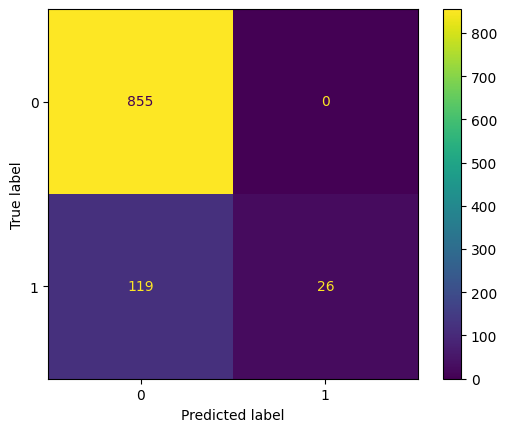

In [104]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [105]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2874


### Treinar Modelo com Validação Cruzada e Tuning de Hiperparâmetros

In [106]:
#Criar um dicionário com os valores dos hipererâmetros a serem testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [107]:
# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando Recall como métrica de validação
rf_model_cv = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=51)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=2)

In [108]:
# Treinar o modelo usando cross-validation para buscar melhores hiperparâmetros
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=51, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=51),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

### Usando o conceito de Cross Validation, nós trabalhamos na verdade com conjunto de Treino + Val + Teste
### X_train(50%) -> cross_validate -> 4 partições para treino + 1 validação
### Gera o melhor modelo e validamos com X_test (50%)

### Análise de Resultado - GridSearchCV

In [109]:
# Retornar o melhor modelo
best_model = grid_search.best_estimator_

In [110]:
# Retornar melhores hiperparâmetros
best_params = grid_search.best_params_

In [111]:
# Apresentar melhores hiperparâmetros
best_params

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [112]:
# Retornar a melhor métrica
best_score = grid_search.best_score_

In [113]:
best_score

np.float64(0.5684729064039409)

### Análise dos Resultados - Baseline

In [114]:
# Fazer predições (classificações - 0 ou 1)
y_pred = best_model.predict(X_test)

In [115]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [116]:
# Retornar as probabilidades das previsões
y_pred_proba = best_model.predict_proba(X_test)

In [117]:
# Mostrar Probabilidades
y_pred_proba

array([[0.86944191, 0.13055809],
       [0.86079266, 0.13920734],
       [0.80922403, 0.19077597],
       ...,
       [0.85627694, 0.14372306],
       [0.52070008, 0.47929992],
       [0.53292135, 0.46707865]])

In [118]:
# Avaliação do Modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       855
           1       0.86      0.50      0.63       145

    accuracy                           0.92      1000
   macro avg       0.89      0.74      0.79      1000
weighted avg       0.91      0.92      0.91      1000



In [119]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [120]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [121]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_xaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

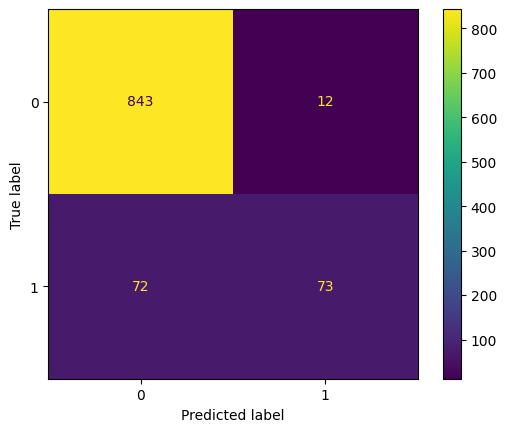

In [122]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [123]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.3886


### Ajustar Threshold

In [124]:
# Criar uma lista de thresholds para testar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Lista para armazenar métrica
recalls = []

# Calcular as métricas para cada threshold
for thresholds in thresholds:
    # Fazer predições com o threshold
    y_pred_threshold = (y_pred_proba[:, 1] >= thresholds).astype(int)

    # Calcular métrica
    recall = recall_score(y_test, y_pred_threshold)

    # Inserir métrica na lista
    recalls.append(recall) 

In [125]:
# Criar Dataframe com os resultados
df_thresholds = pd.DataFrame({'Threshold': thresholds, 'Recall': recalls})

In [126]:
df_thresholds.head(10)

,Threshold,Recall
0,0.7,0.848276
1,0.7,0.682759
2,0.7,0.503448
3,0.7,0.248276
4,0.7,0.089655


In [130]:
# Encontrar o threshold com melhor recall
melhor_threshold = df_thresholds.loc[df_thresholds['Recall'].idxmax()]

print(f'Maior Threshold: {melhor_threshold["Threshold"]:.2f}')
print(f'Maior Recall: {melhor_threshold["Recall"]:.4f}')

Maior Threshold: 0.70
Maior Recall: 0.8483


In [128]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(go.Scatter(x=thresholds, y=recalls, name='Recall', line=dict(color='blue')))

fig.update_layout(
    title='Recall por Threshold',
    xaxis_title='Threshold',
    yaxis_title='Recall Score',
    width=800,
    height=500
)

fig.show()

ValueError: 
    Invalid value of type 'builtins.float' received for the 'x' property of scatter
        Received value: 0.7

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

### Análise de Métricas com Threshold

In [132]:
# Fazer predições
y_pred = (y_pred_proba[:, 1] >= melhor_threshold['Threshold']).astype(int)

In [133]:
# Avaliação do Modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       855
           1       1.00      0.09      0.16       145

    accuracy                           0.87      1000
   macro avg       0.93      0.54      0.55      1000
weighted avg       0.89      0.87      0.82      1000



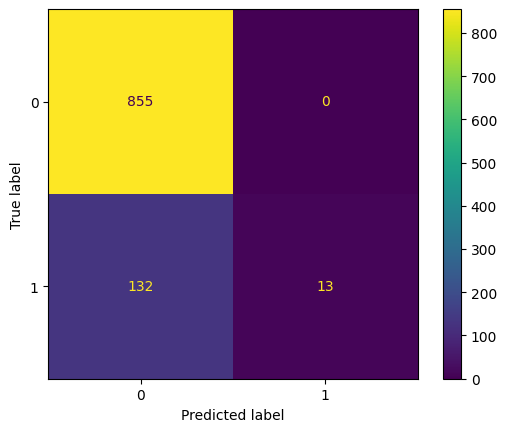

In [134]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

### Interpretabilidade

In [136]:
# Importância das variáveis

# Obter a importância das variáveis
importancias = best_model.feature_importances_
nomes_features = preprocessor.get_feature_names_out()

# Criar um Dataframe com as importâncias e nomes das features
df_impotances = pd.DataFrame({'feature': nomes_features, 'importancia': importancias})

# Ordenar o Dataframe por importância (decrescente)
df_impotances = df_impotances.sort_values('importancia', ascending=False).reset_index(drop=True)

In [139]:
# Criar um gráfico com as importâncias
fig = px.bar(
    df_impotances.head(10), # 10 features mais importantes
    x='importancia',
    y='feature',
    orientation='h',
    title='Importãncia das 10 principais features',
    labels={'importancia': 'Importancia', 'feature': 'Feature'},
    color='importancia',
    color_continuous_scale='Viridis'
)

# Personalizar o layout 
fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [141]:
# Visualizar as árvores da Random Forest

# Função para visualizar árvore
def visualizar_arvore(modelo, indice_arvore, max_profundidade=5):
    plt.figure(figsize=(20,10))
    plot_tree(modelo.estimators_[indice_arvore],
              feature_names=nomes_features,
              class_names=['0', '1'],
              filled=True,
              rounded=True,
              max_depth=max_profundidade,
              fontsize=9,
              proportion=True,
              precision=2)
    plt.title(f'Árvore {indice_arvore} da Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()

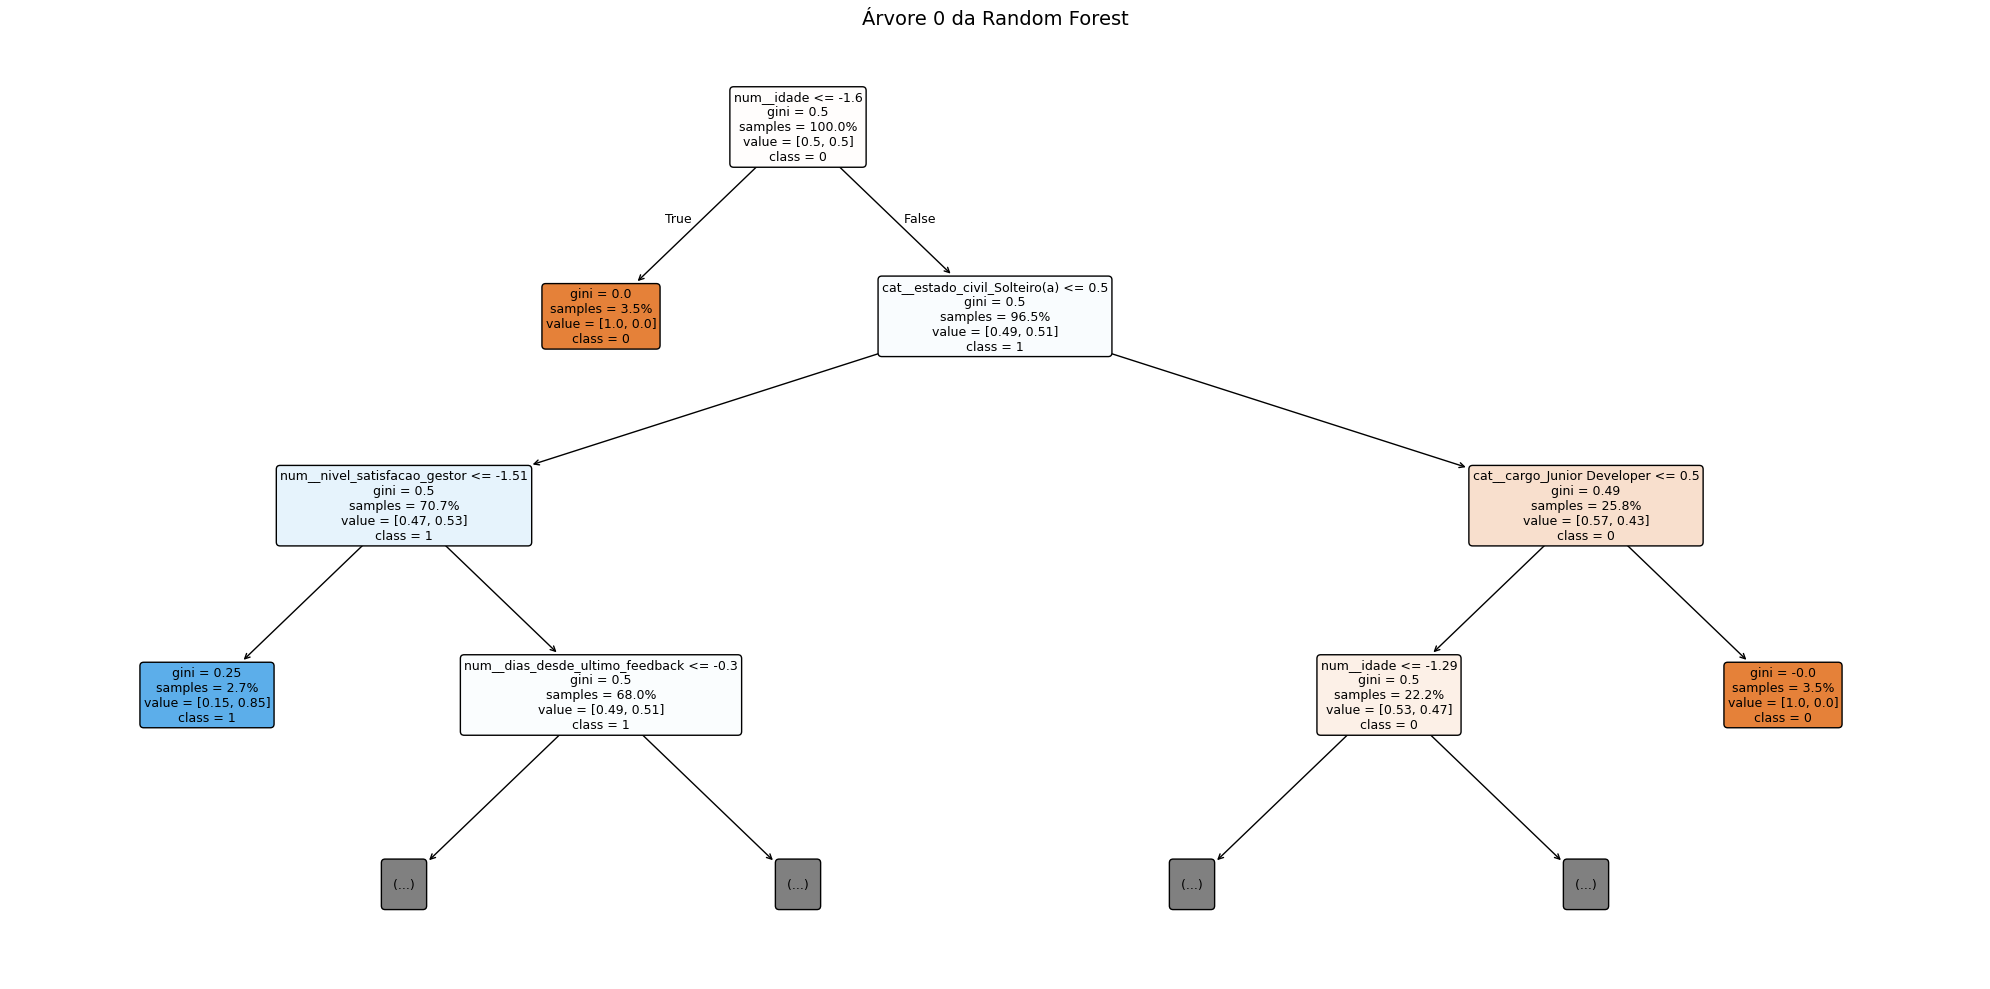

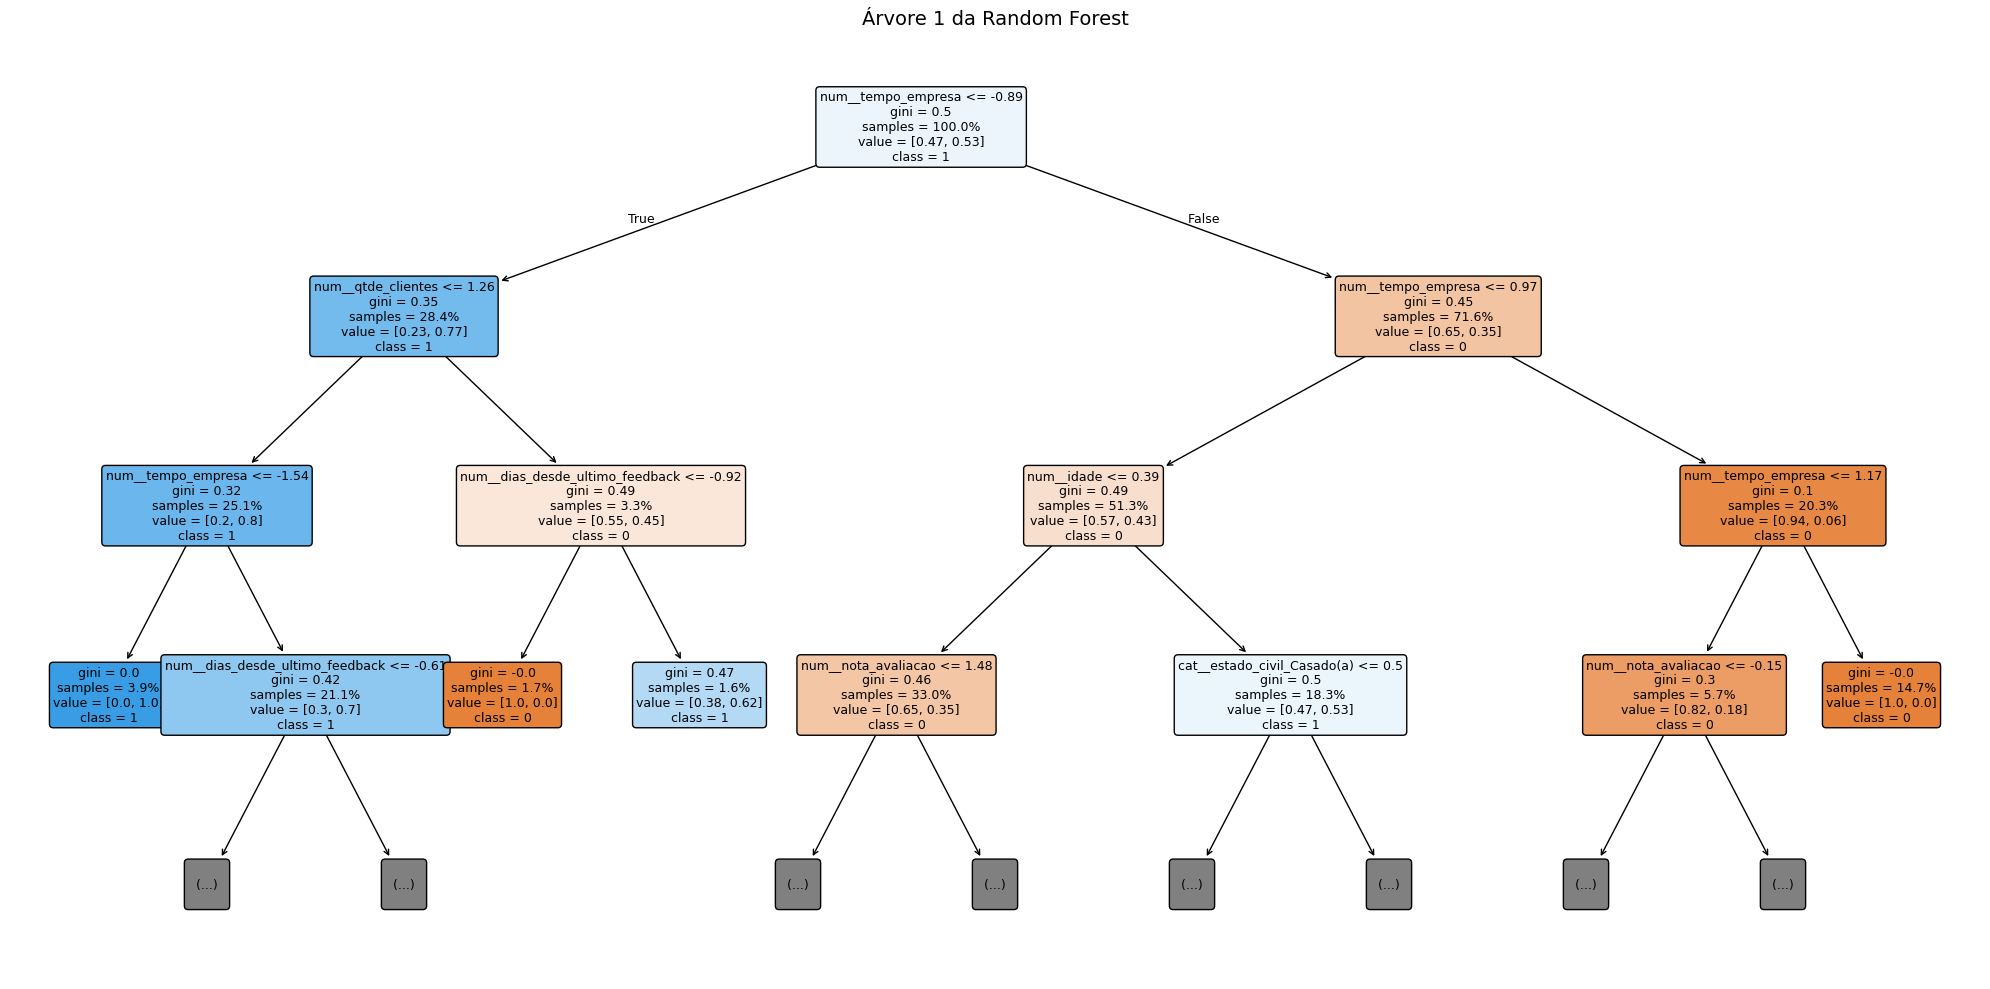

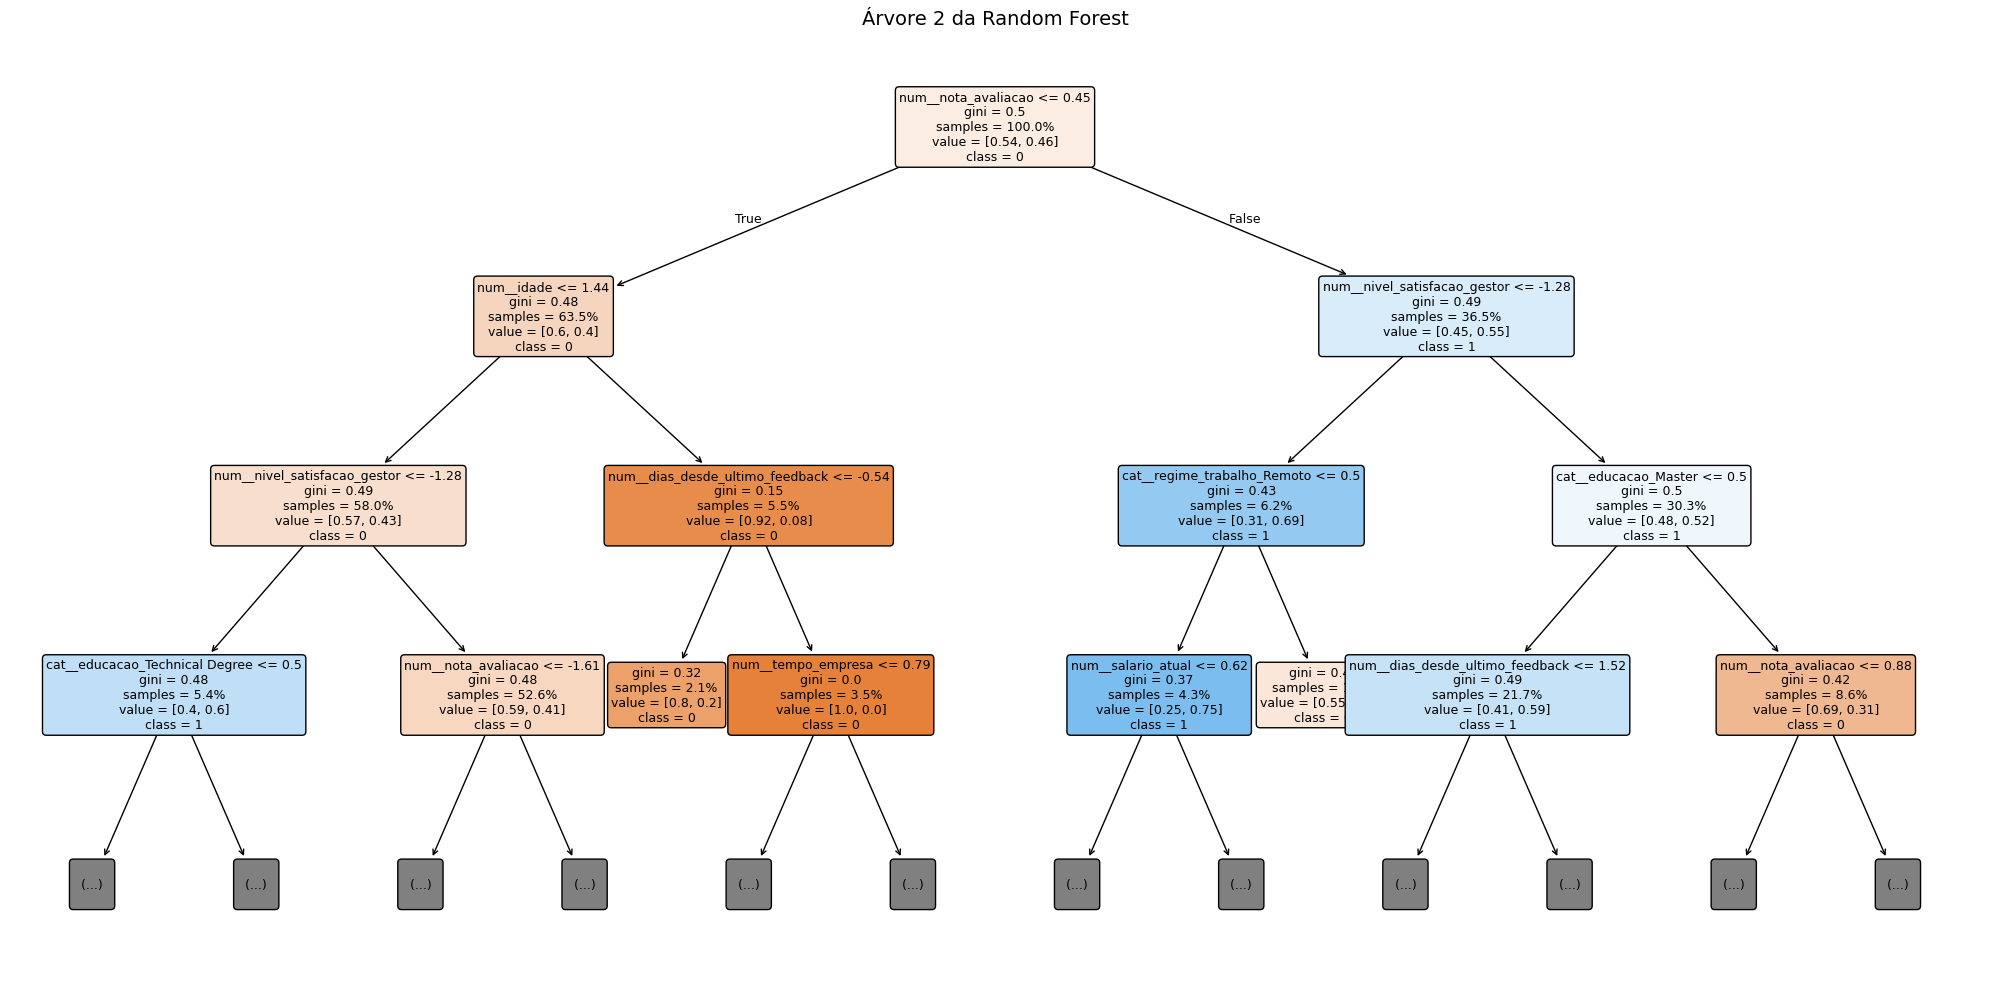

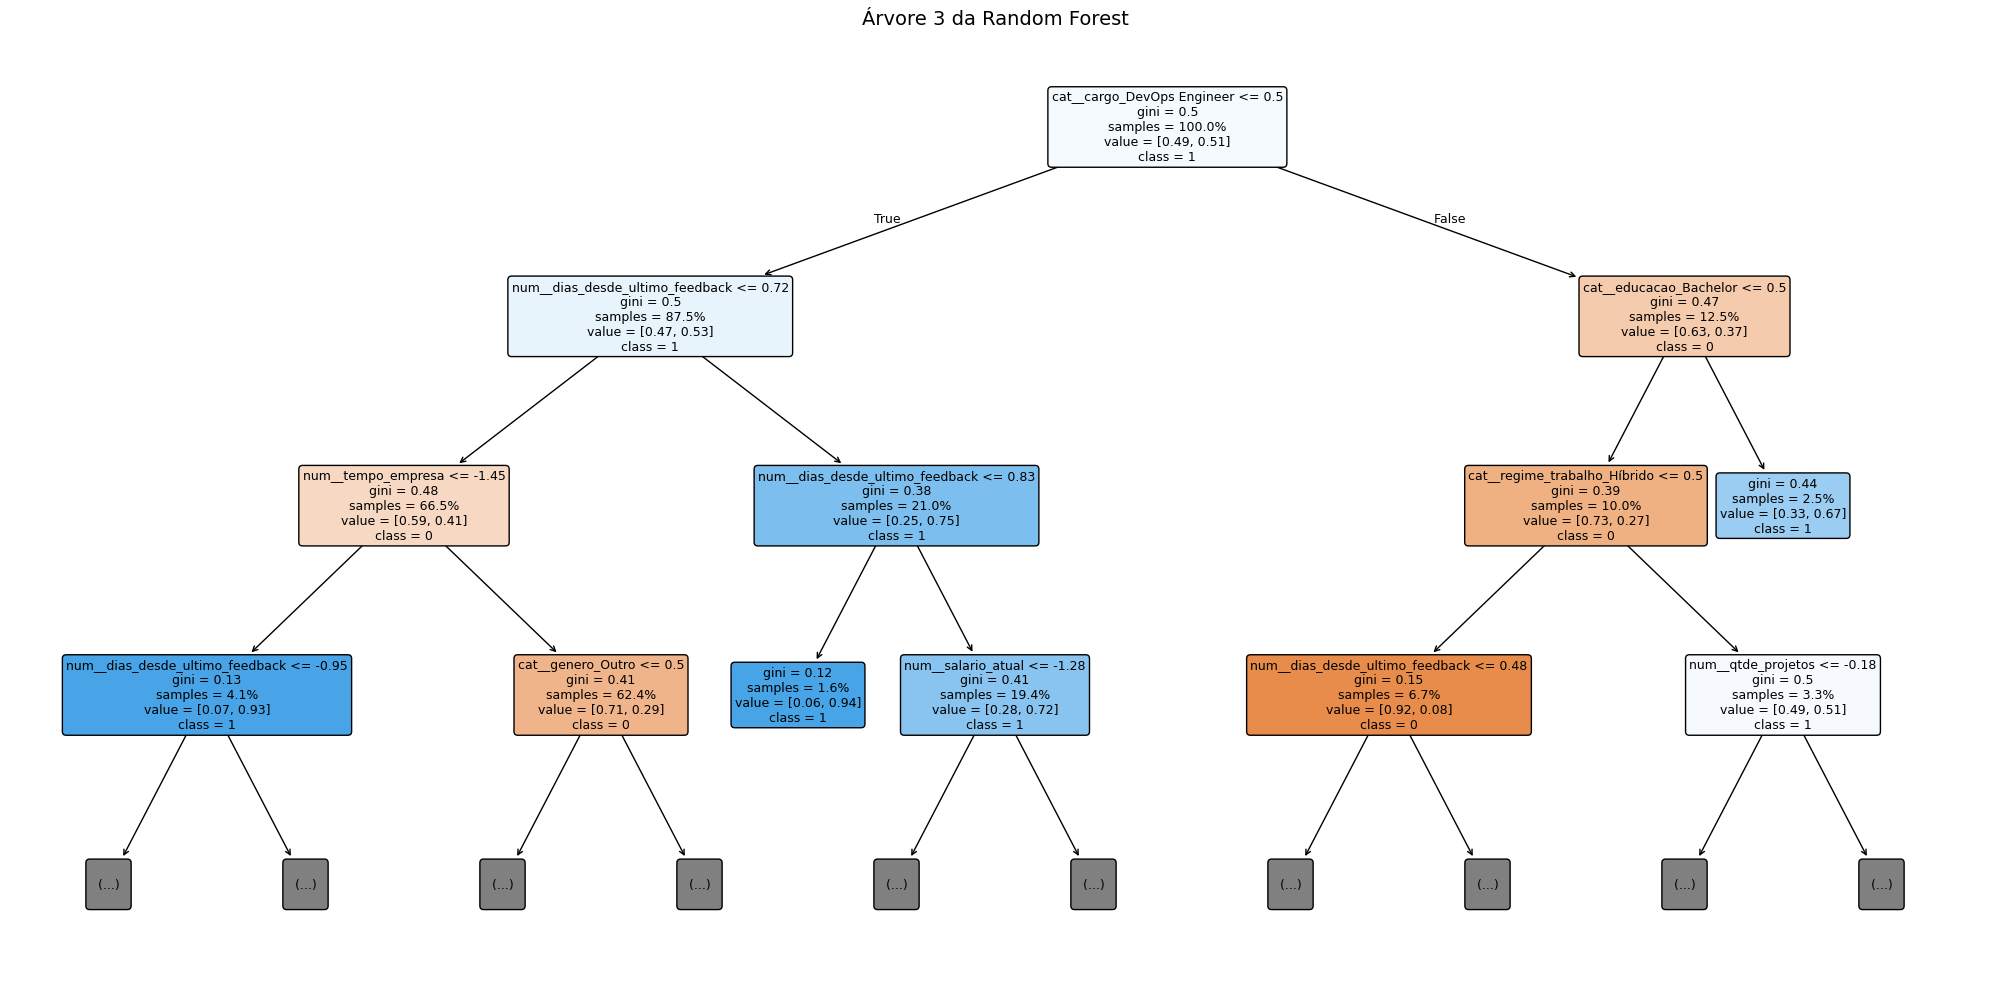

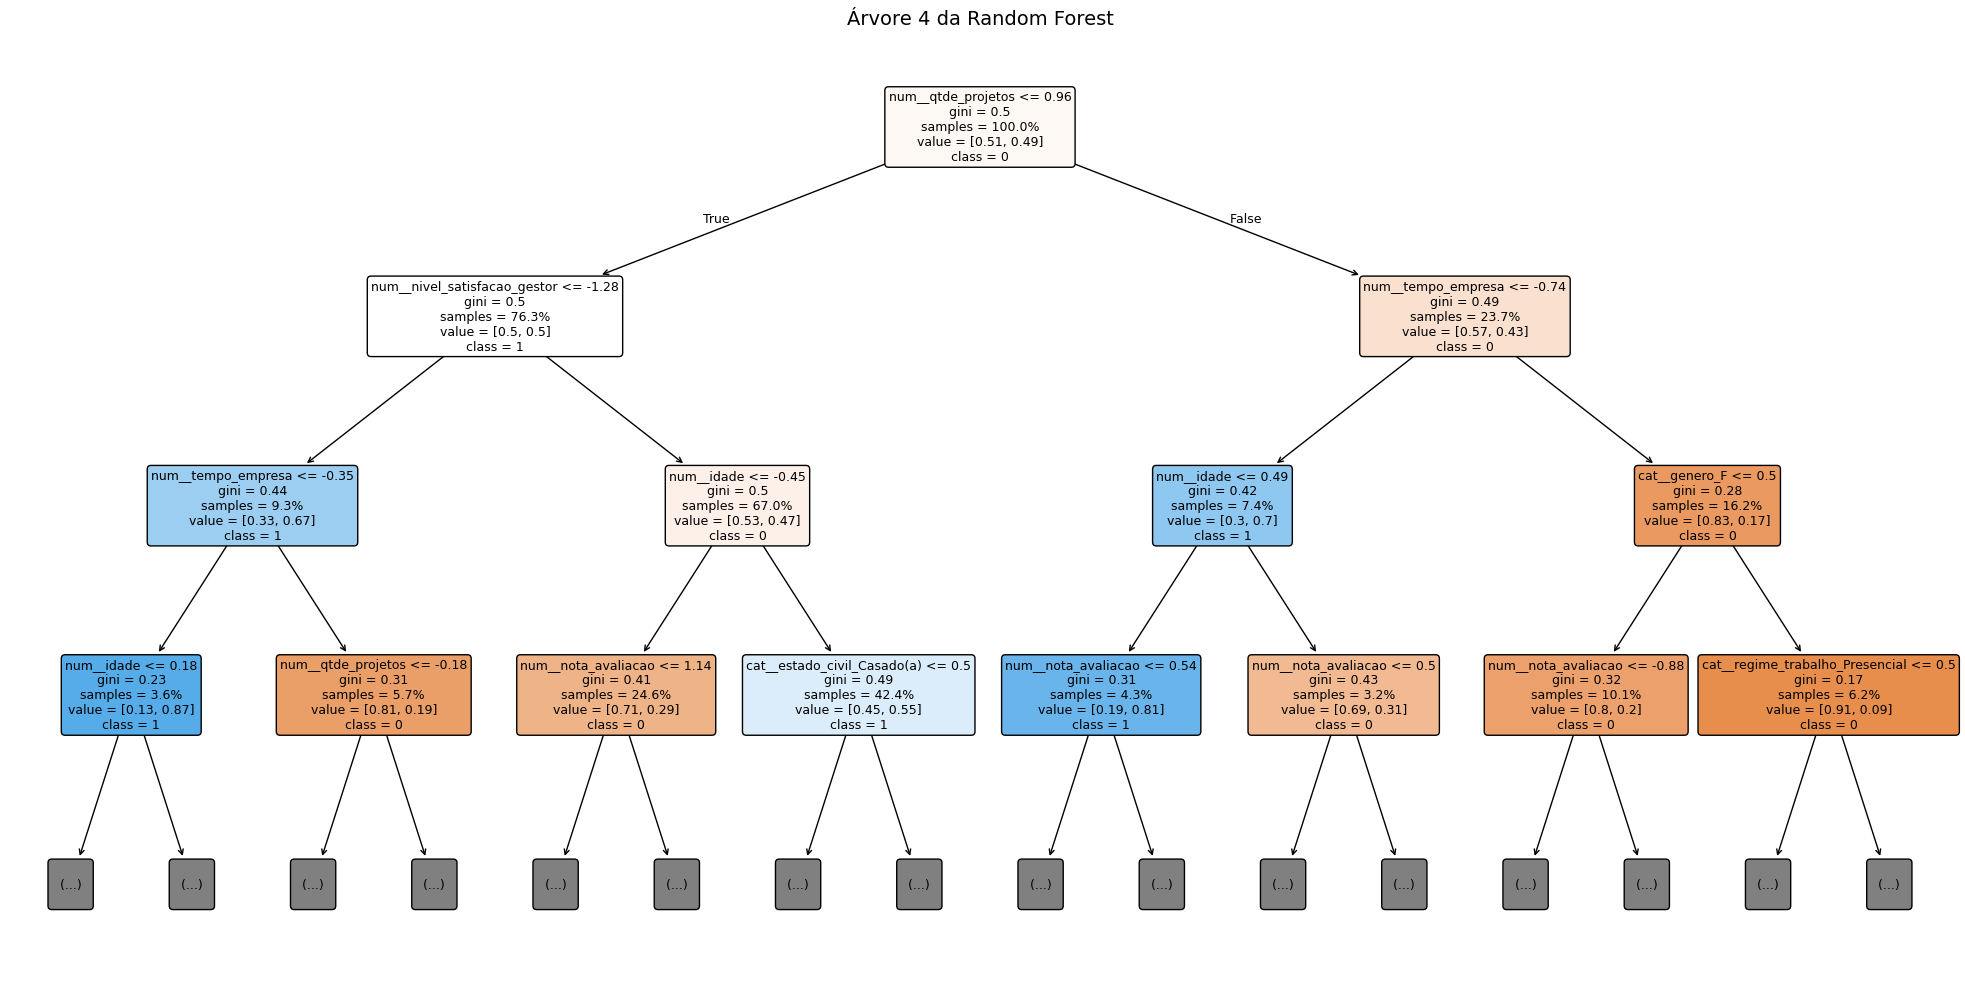

In [142]:
# Visualizar as 5 primeiras árvores
for i in range(5):
    visualizar_arvore(best_model, i, 3)

### Apresentar Plots Shapley Values

In [144]:
# Rodar o explainer no ocnjunto de treinamento
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=nomes_features)

In [145]:
# Calcular Shapley Values no conjunto de testes
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [09:08,  1.81it/s]                          


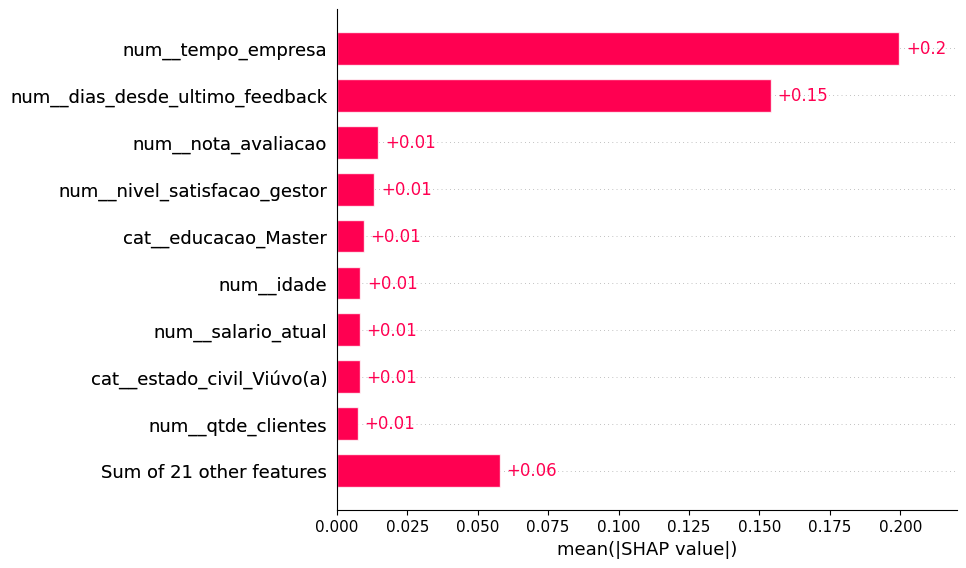

In [146]:
# Plotar a contribuição global por Shapley Values
shap.plots.bar(shap_values_class)

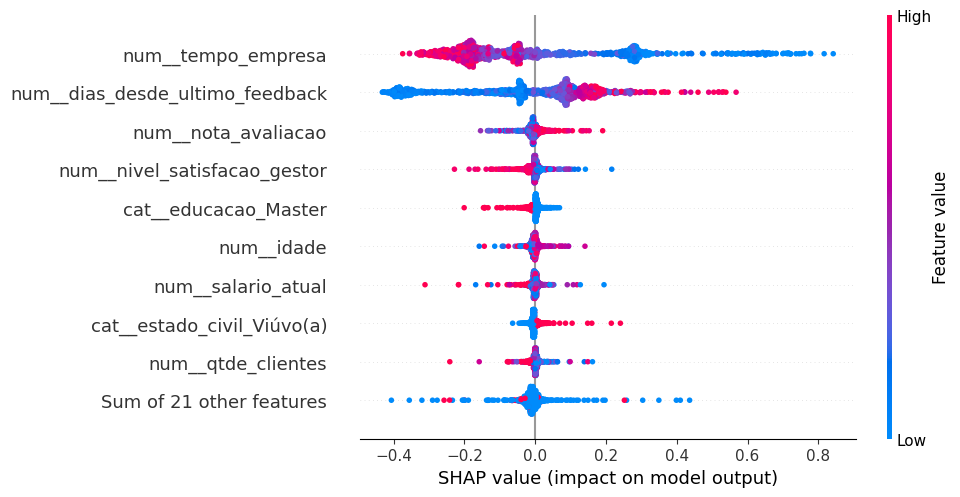

In [147]:
# Plot de Beeswarm Global
shap.plots.beeswarm(shap_values_class, max_display=10)

In [148]:
# Criar um Dataframe contendo y_test e y_pred
df_comparacao = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [149]:
# Mostrar DataFrame
df_comparacao

,y_test,y_pred
1617,0,0
885,0,0
433,0,0
188,0,0
1264,0,0
...,...,...
784,0,0
1914,0,0
227,1,0
316,1,0


In [150]:
# Valor real (227)
y_test[227]

np.int64(1)

In [151]:
# Valor Predito (227)
y_pred[227]

np.int64(0)

In [152]:
# Mostrar os dados do indice 227
X_test[227]

array([-0.50087032,  1.66458541, -0.10520997,  0.77154649,  0.01045753,
       -0.49864509,  0.06106527, -1.15716535,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [161]:
def inverse_transform_manual(X_transformed, preprocessor, feature_names):

    # Armazenar nomes originais das features
    feature_names_original = feature_names

    # Criar um Dataframe com os dados transformador
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

    # Criar um Dataframe vazio para receber os dados originais
    df_original = pd.DataFrame(columns=feature_names_original)
    
    #Loop em cada transformador
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
             #Para features numéricas, usar o inverse_transform
             df_original[features] = transformer.inverse_transform(
                 df_transformed[[f'{name}__{f}' for f in features]]
             )
        elif name == 'cat':
            # Para features categorias, precisamos indentificar as colunas e qual delas tem o valor 1
            for feature in features:
                cols = [col for col in df_transformed.columns if col.startswith(f'{name}__{feature}')]
                for col in cols:
                    if df_transformed[col].iloc[0] == 1:
                        # split -> H_Y_U - split('__') = 
                        df_original[feature] = col.split('__')[-1]
                        break
    return df_original                    

In [162]:
# Trazer dados originais do index 227
inverse_transform_manual(X_test[[227]], preprocessor, X.columns)

,idade,genero,estado_civil,educacao,regime_trabalho,cargo,salario_atual,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback
0,33.0,genero_Outro,estado_civil_Viúvo(a),educacao_PhD,regime_trabalho_Presencial,cargo_Product Manager,24347.0,7.9,NaN,7.0,4.0,4.1,942.0,93.0


In [163]:
# Probabilidade do index 227
y_pred_proba[227]

array([0.791836, 0.208164])

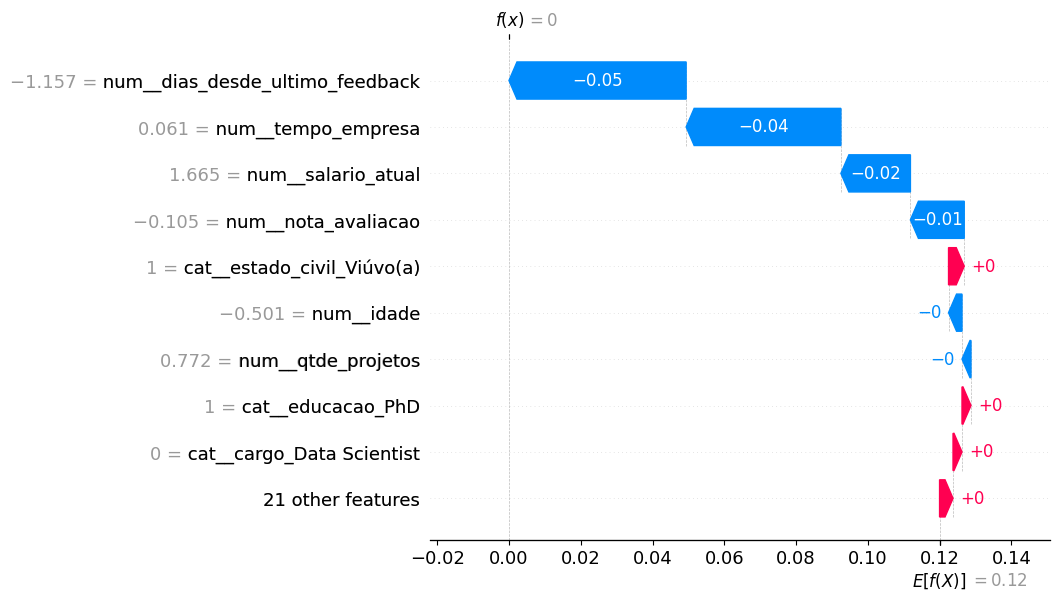

In [164]:
# Plotar os Shap Values para um exemplo específico
shap.plots.waterfall(shap_values_class[227], max_display=10)